In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = "/run/media/alexm/Storage/Data Sources/train"
TEST_DIR = "/run/media/alexm/Storage/Data Sources/test"
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = "dogsvscats-{}-{}.model".format(LR, "6conv-basic")

In [2]:
def label_img(img):
    # ex: dog.93.png
    word_label = img.split('.')[-3]
    if word_label == "cat": return [1, 0]
    elif word_label == "dog": return [0, 1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
        
    shuffle(training_data)
    np.save("train_data.npy", training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    
    shuffle(testing_data)
    np.save("test_data.npy", testing_data)
    return testing_data

In [5]:
# train_data = create_train_data()
# The following should be run if you already have training data:
train_data = np.load("train_data.npy")

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
if os.path.exists("{}.meta".format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print("Model loaded.")

INFO:tensorflow:Restoring parameters from /home/alexm/Dropbox/Coding/Programming Languages/Python/Personal Programs/Machine Learning/src/dogsvscats-0.001-6conv-basic.model
Model loaded.


In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [9]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [13]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.30066 | time: 10.526s
| Adam | epoch: 010 | loss: 0.30066 - acc: 0.8747 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.29571 | time: 11.557s
| Adam | epoch: 010 | loss: 0.29571 - acc: 0.8732 | val_loss: 0.54188 - val_acc: 0.7900 -- iter: 24500/24500
--


In [ ]:
# tensorboard --logdir=/home/alexm/Dropbox/Coding/Programming\ Languages/Python/Personal\ Programs/Machine\ Learning/src/log

In [14]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/alexm/Dropbox/Coding/Programming Languages/Python/Personal Programs/Machine Learning/src/dogsvscats-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


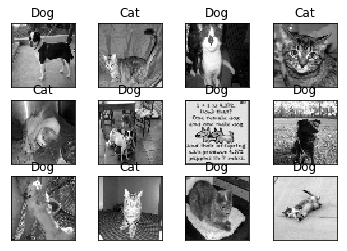

In [20]:
import matplotlib.pyplot as plt

# This is in case you don't have this file yet.
# test_data = process_test_data()

# This is in case you already have this file.
test_data = np.load("test_data.npy")

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num + 1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label = "Dog"
    else: str_label = "Cat"
        
    y.imshow(orig, cmap="gray")
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()

In [21]:
with open("submission-file.csv", "w") as f:
    f.write("id, label\n")

In [22]:
with open("submission-file.csv", "a") as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        model_out = model.predict([data])[0]
        f.write("{},{}\n".format(img_num, model_out[1]))

100%|██████████| 12500/12500 [01:20<00:00, 155.08it/s]
